 ## HW4 - EuroSAT Land Use and Land Cover Classification using Deep Learning
 
In this homework your task is to implement deep learning models to solve a typical problem in satellite imaging  using a benchmark dataset. The homework was designed to make you work on increasingly more complex models. We hope that the homework will be very helpful to improve your skills and knowledge in deep learning!


### S1:

- Visit the EuroSAT data description page and download the data: https://github.com/phelber/eurosat

- Split the data into training (50%) and testing sets (50%), stratified on class labels (equal percentage of each class type in train and test sets).

- Convert each RGB image to grayscale and flatten the images into a data matrix (n x p: n = #samples, p = #pixels in each image)


In [3]:
!pip install tensorflow

In [10]:
## import packages
import os, cv2
import numpy as np 
import pandas as pd 
import math
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import PIL
import PIL.Image

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf

In [7]:
## Mount drive folder
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
imgs = []
path = "/content/drive/MyDrive/Grad School/Penn_MUSA/Spring2022/650_RemoteSensing/Homework/HW4/Data/EuroSAT_RGB/"

In [ ]:
## Get image size
img = PIL.Image.open("{}/AnnualCrop/AnnualCrop_1.jpg".format(path))
width, height = img.size
print(width)
print(height)

batch_size = 32
img_height = 64
img_width = 64

In [22]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  path,
  labels="inferred",
  validation_split=0.5,
  subset="training",
  seed=123,
  shuffle="true",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 27000 files belonging to 10 classes.
Using 13500 files for training.


In [23]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  path,
  labels="inferred",
  validation_split=0.5,
  subset="validation",
  seed=123,
  shuffle="true",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 27000 files belonging to 10 classes.
Using 13500 files for validation.


In [20]:
class_names = train_ds.class_names
print(class_names)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


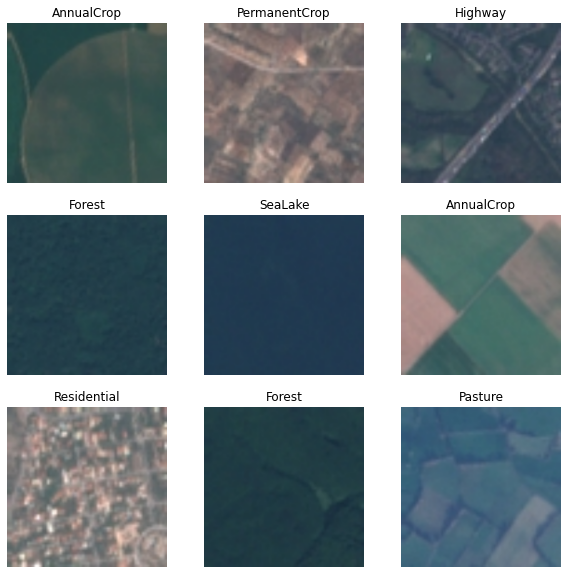

In [28]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [29]:
train_ds.

<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

### S2:

- Implement a first deep learning model (M.1) using a fully connected network with a single fully connected layer (i.e: input layer + fully connected layer as the output layer). 

Q2.1: Calculate classification accuracy on the test data.  

### S3:

- Implement a second deep learning model (M.2) adding an additional fully connected hidden layer (with an arbitrary number of nodes) to the previous model. 

Q3.1: Calculate classification accuracy on the test data.  

### S4:

- Implement a third deep learning model (M.3) adding two additional fully connected hidden layers (with arbitrary number of nodes) for a total of four, as well as drop-out layers to the previous model. 

Q4.1: Calculate classification accuracy on the test data.

Q4.2: Compare against previous models. Which model was the "best"? Why?

### S5:

- Take the original RGB images and do not vectorize them. Use these images as the data input for the following models (M.4 and M.5).
- Implement a fourth CNN model (M.4) that includes the following layers: Conv2D, MaxPooling2D, Dropout, Flatten, Dense. 

Q5.1: Calculate classification accuracy on the test data.

Q5.2: Compare against previous models. Which model was the "best"? Why?

### S6:

- Using RGB images from S5, implement a fifth deep learning model (M.5) targeting accuracy that will outperform all previous models. You are free to use any tools and techniques, as well as pre-trained models for transfer learning. 

Q6.1: Describe the model you built, and why you chose it.

Q6.2: Calculate classification accuracy on the test data.

Q6.3: Compare against previous models. Which model was the "best"? Why?

Q6.4: What are the two classes with the highest labeling error? Explain using data and showing mis-classified examples.

### S7:

- Apply your best model on multispectral images. You may use whichever image channels you wish, so long as you use more than just RGB (although you are not required to use any color channels).

Q7.1: Calculate classification accuracy on the test data.

Q7.2: Compare against results using RGB images.